# MRI reconstruction from multicoil data

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from models import *
from utils import *

from PIL import Image
import PIL
import h5py
from skimage.metrics import structural_similarity as ssim
import pickle
from common.subsample import MaskFunc

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms
from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.cuda.set_device(0)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 3


# Loading MRI measurement

In [2]:
### Get image from the validation set
filename = '/hdd/multicoil_val/file1000190.h5' # good (scale: 3.2) 140 channels

f = h5py.File(filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']
print("Kspace shape (number slices, number coils, x, y): ", f['kspace'].shape)

# which slice to consider in the following
slicenu = f["kspace"].shape[0]//2 # pick the center slide

slice_ksp = f['kspace'][slicenu]

slice_ksp_torchtensor = transform.to_tensor(slice_ksp)      # Convert from numpy array to pytorch tensor
slice_image = transform.ifft2(slice_ksp_torchtensor)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = transform.complex_abs(slice_image)   # Compute absolute value to get a real image

Kspace shape (number slices, number coils, x, y):  (36, 15, 640, 368)


In [3]:
numit = 30000
LR=0.01

In [4]:
from models import skip_decoder

output_depth = slice_ksp.shape[0]*2
out_size = slice_ksp.shape[1:]

pad = "zero" #'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

input_depth = 32
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03
num_channels = 256
in_size = ( slice_ksp.shape[-2]//(2**6),slice_ksp.shape[-1]//(2**6) )
parnet = skip_decoder.skip_decoder(num_channels, output_depth, 
           num_channels_down = [num_channels] * 6,
           num_channels_up =   [num_channels*2] * 6, ######### note that I pass 2*(number of channels) here (doesn't make a significant difference, though)
           num_channels_skip =    [num_channels*0] * 6,  
           filter_size_up = 3, filter_size_down = 5, 
           upsample_mode='nearest', filter_skip_size=1,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='ReLU',out_size=slice_ksp.shape[-2:]).type(dtype)

In [5]:
in_size

(10, 5)

In [6]:
parnet

Sequential(
  (1): Sequential(
    (1): Sequential(
      (1): Sequential(
        (1): Sequential(
          (1): Sequential(
            (1): Sequential(
              (1): Sequential(
                (1): Sequential(
                  (1): Sequential(
                    (1): Sequential(
                      (1): Sequential(
                        (1): Upsample(scale_factor=2, mode=nearest)
                      )
                      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                      (3): Sequential(
                        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                      )
                      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                      (5): ReLU()
                      (6): Sequential(
                        (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
                      )
                      (

In [7]:
scaling_factor = get_scale_factor(parnet,
                                   num_channels,
                                   in_size,
                                   slice_ksp,)

In [8]:
scaling_factor

12482.55261715093

In [9]:
slice_ksp_torchtensor = slice_ksp_torchtensor * scaling_factor
slice_ksp = slice_ksp * scaling_factor

In [10]:
mask_filename = '/hdd/multicoil_test_v2/file1001187_v2.h5' #4x mask Test
f_mask = h5py.File(mask_filename, 'r')
mask = np.array(f_mask[list(f_mask.keys())[2]])

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d = mask.copy()
mask1d[:mask1d.shape[-1]//2-160] = 0 
mask1d[mask1d.shape[-1]//2+160:] =0
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()

masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask = mask)
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)
sampled_image = transform.ifft2(masked_kspace)

## Least-squares estimate from full kspace measurement

The least-squares estimate is obtained from the full kspace measurement by first computing the least estimate for each coil slice and then computing an estimate of the final image via the root sum of squares algorithm:
$$
x_{result} = \sqrt{\sum_{i=1}^n x_i }.
$$
Here, $x_i$ is the $i$-th entry of the image.

In [11]:
# kspace is (numslices, x, y) dimensional and complex-valued
# need (1,numslices,x,y) as output of decoder
# forward model
#    input: (1,numslices,x,y), complex-valued
#    output: (1,numslices,x,y,2), real-valued, where the 2 at the end corresponds to real and complex parts

# generate measurement
def ksp2measurement(ksp):
    return np_to_var( np.transpose( np.array([np.real(ksp),np.imag(ksp)]) , (1, 2, 3, 0)) )

measurement = ksp2measurement(slice_ksp).type(dtype)

In [12]:
# reconstruct from full kspace measurement with build-in function
slice_image_rss = transform.root_sum_of_squares(slice_image_abs, dim=0)

In [13]:
# reconstruct from full kspace measurement by hand
def lsreconstruction(measurement,mode='both'):
    # measurement has dimension (1, num_slices, x, y, 2)
    fimg = transform.ifft2(measurement)
    normimag = torch.norm(fimg[:,:,:,:,0])
    normreal = torch.norm(fimg[:,:,:,:,1])
    print("real/img parts: ",normimag, normreal)
    if mode == 'both':
        return torch.sqrt(fimg[:,:,:,:,0]**2 + fimg[:,:,:,:,1]**2)
    elif mode == 'real':
        return torch.tensor(fimg[:,:,:,:,0]) #torch.sqrt(fimg[:,:,:,:,0]**2)
    elif mode == 'imag':
        return torch.sqrt(fimg[:,:,:,:,1]**2)

In [14]:
def root_sum_of_squares(lsimg):
    out = np.zeros(lsimg[0].shape)
    for img in lsimg:
        out += img**2
    return np.sqrt(out)

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

### Original image

real/img parts:  tensor(484.2709, device='cuda:0') tensor(434.0468, device='cuda:0')


(-0.5, 319.5, 319.5, -0.5)

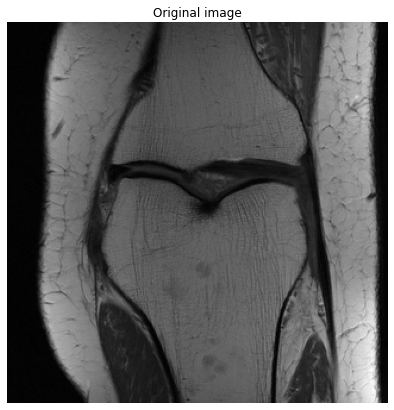

In [15]:
lsimg = lsreconstruction(measurement)
lsrec = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax1 = fig.add_subplot(121)
ax1.imshow(lsrec,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

# Reconstruction with decoder part of the Deep Image Prior

### Define forward model

In [16]:
def channels2imgs(out):
    sh = out.shape
    chs = int(sh[0]/2)
    imgs = np.zeros( (chs,sh[1],sh[2]) )
    for i in range(chs):
        imgs[i] = np.sqrt( out[2*i]**2 + out[2*i+1]**2 )
    return imgs

In [17]:
# the forward model - treats real and complex part of each slice as a separate channel
def forwardm(img,mask):
    # img has dimension (2*num_slices, x,y)
    # output has dimension (1, num_slices, x, y, 2)
    mask = np_to_var(mask)[0].type(dtype)
    s = img.shape
    ns = int(s[1]/2) # number of slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    Fimg = transform.fft2(fimg) # dim: (1,num_slices,x,y,2)
    for i in range(ns):
        Fimg[0,i,:,:,0] *= mask
        Fimg[0,i,:,:,1] *= mask
    return Fimg

### Fit

In [19]:
num_param(parnet)

14588446

In [20]:
out = []
for img in sampled_image:
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
lsest = torch.tensor(np.array([out]))

In [21]:
sover,pover,par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,
                                                num_channels=[num_channels]*(5),
                                                #reg_noise_decayevery = rnd,
                                                #reg_noise_std=rn,
                                                num_iter=numit,
                                                LR=LR,
                                                mask = mask2d,
                                                apply_f = forwardm,
                                                img_noisy_var=unders_measurement,
                                                net=parnet,
                                                upsample_mode="free",
                                                img_clean_var=Variable(lsest).type(dtype),
                                                lsimg = lsimg,
                                                find_best=True,)

input shape:  [1, 256, 10, 5]
optimize with adam 0.01


In [22]:
par_out_chs = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
par_out_imgs = channels2imgs(par_out_chs)
# least squares reconstruciton
lsimg = lsreconstruction(measurement)
orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

# deep decoder reconstruction
prec = crop_center(root_sum_of_squares(par_out_imgs),320,320)

ssim_const = ssim(orig, prec,data_range=orig.max())

psnr_const = psnr(orig,prec,np.max(orig))

real/img parts:  tensor(484.2709, device='cuda:0') tensor(434.0468, device='cuda:0')


In [23]:
psnr_const,ssim_const

(31.52641900357745, 0.800416568812908)

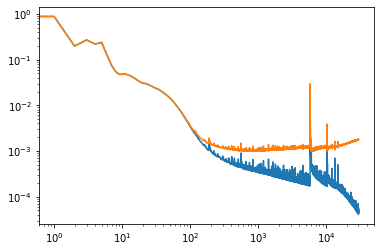

In [24]:
plt.loglog(par_mse_n)
plt.loglog(par_mse_t)
plt.show()

### PSNR over the iterations

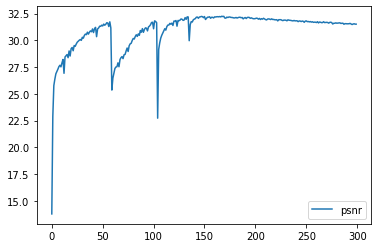

In [25]:
plt.plot(pover,label="psnr")
plt.legend()
plt.show()

### SSIM over the iterations

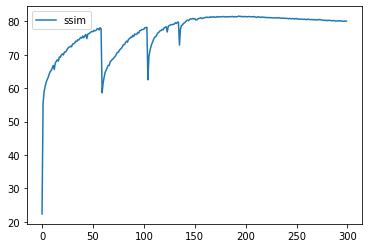

In [26]:
plt.plot(100*np.array(sover),label="ssim")
plt.legend()
plt.show()

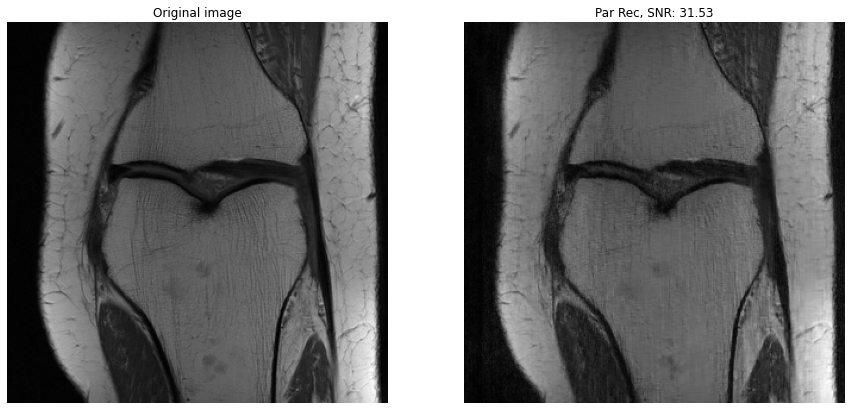

In [27]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(prec,cmap='gray')
ax2.set_title( "Par Rec, SNR: %.2f" % psnr(orig,prec,np.max(orig) ) ) 
ax2.axis('off')    
    
plt.show()

### The original deep image prior which in addition to the decoder, has an encoder and skip connections
As you can see, in terms of psnr, the original DIP gives 1dB more than the decoder (but by stopping decoder fitting a bit earlier, this difference will be eliminated). In terms of texture details, the decoder output (the above image) is slightly better.

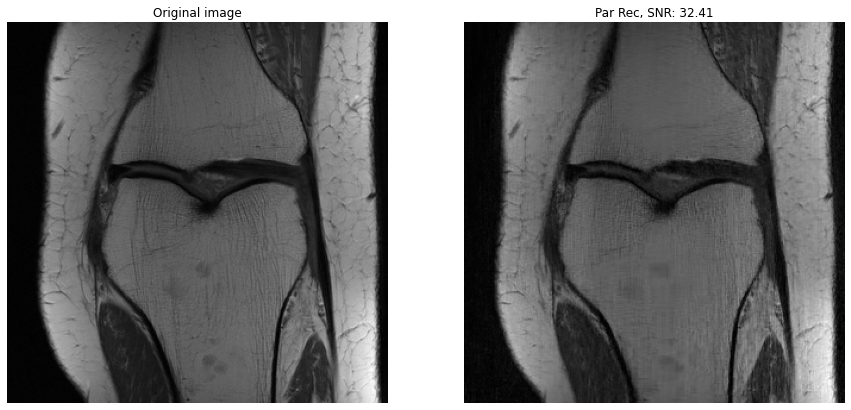

In [24]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(prec,cmap='gray')
ax2.set_title( "Par Rec, SNR: %.2f" % psnr(orig,prec,np.max(orig) ) ) 
ax2.axis('off')    
    
plt.show()